### Objective: 
In this notebook, I am trying to figure out how to do the following stuff. 

1. Compute the correlation between the different electrodes for each signal. 
2. Determine how to compute the periodgram for each. 


In [115]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from os.path import join,dirname, split
from numpy import linalg as la
from os import listdir
from scipy.io import loadmat
from GraphingSetup import configure_plots, create_tableau_colors
%matplotlib inline
configure_plots()
tableau = create_tableau_colors()

sns.set_style('white')
sns.set_context('talk')

In [2]:
def load_data(path,convert_index=True):
    """converts the data to a pandas object
    Parameters: 
        path(str): absolute path to the m file 
        convert_index(bool): if True, convert the index to a time delta
    Returns: 
        (data,sampling_rate,sequence):(pd.DataFrame, int, int) 
    """
    # load the matlab file and extract the data
    data = loadmat(path)['dataStruct']
    
    # get the sampling rate and cast to int
    sampling_rate = int(data['iEEGsamplingRate'][0][0])
    
    #extract the iEEG traces and electrode channel data and place into a data frame
    traces = data['data'][0][0]
    channels = data['channelIndices'][0][0][0]
    df = pd.DataFrame(traces, columns = channels)
    
    if convert_index: 
        df.index = convert_index_to_timedelta(df.index, sampling_rate)
    
    #get the sequence collection number if present (not present in test)
    sequence = -1
    if 'sequence' in data.dtype.names:
        sequence =int(data['sequence'])

    return df, sampling_rate, sequence

In [3]:
base = '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG'
train1_path = join(base, 'train_1')
train2_path = join(base, 'train_2')
train3_path = join(base, 'train_3')

def get_files():
    """gets the file names"""
    base = '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG'
    path1 = join(base, 'train_1')
    path2 = join(base, 'train_2')
    path3 = join(base, 'train_3')

    def get_fs(path):
        return [join(path, f) for f in listdir(path) if f.endswith('.mat')]

    return get_fs(path1) + get_fs(path2) + get_fs(path3)


In [4]:
filenames = get_files()

In [5]:
data =load_data(filenames[0], convert_index =False)[0]

### Extract the correlation
Below, I just do the correlation between the signals. 

In [11]:
## Extract the eigenvalues from the correlation matrix
c = data.corr()

pandas.core.frame.DataFrame

In [187]:
def extract_correlations(data):
    """Calculate the correlation matrix for time series with its associated eigenvalues and the eigenvalues
    Parameters:
        data(pd.DataFrame): Data frame with the time series data
    Returns:
        corr(pd.Series): The correlations the time series
        eigs(pd.Series): The eigenvalues.

    """
    
    def format_tuple(t):
        """Helper function to arrange tuples."""
        # convet to list and sort
        t = sorted(list(t))
        return 'corr(%d,%d)'%(t[0],t[1])

    # calculate the correlation matrix and its eigenvalues
    corr = data.corr()
    eigs = pd.Series(la.eigvals(corr))
    
    # manipulate the corr data
    corr.values[np.tril_indices_from(corr)] = np.nan
    corr = corr.unstack()
    corr = corr[corr.isnull() == False]
    
    # rename the indexes for the correlation
    corr.index = map(format_tuple, corr.index.tolist())
    
    # change the name of the eigs
    eigs.index = map(lambda x: 'eig_%d'%(x+1), list(eigs.index))
    

    return pd.DataFrame(pd.concat([corr, eigs])).T


In [188]:
res= extract_correlations(data)

In [189]:
res

,"corr(1,2)","corr(1,3)","corr(2,3)","corr(1,4)","corr(2,4)","corr(3,4)","corr(1,5)","corr(2,5)","corr(3,5)","corr(4,5)",...,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16
0,0.413663,0.254337,0.311173,0.011521,-0.038443,0.116131,-0.070827,-0.10736,-0.098991,-0.063343,...,0.001385,0.813147,0.750338,0.710522,0.172071,0.571452,0.490635,0.298783,0.416663,0.379067


### Now do some of the frequency analysis

I'll have to read more into this, but lets get started!

When the input a is a time-domain signal and A = fft(a), np.abs(A) is its amplitude spectrum and np.abs(A)**2 is its power spectrum. The phase spectrum is obtained by np.angle(A).

In [47]:
import numpy.fft as fft
import scipy.signal as signal

In [55]:
# get the first signal 
a = data[1.0]

# compute the fourier transform
A = fft.fft(a)

# compute the amplitude
amplitude = np.abs(A)

# compute the power 
power = np.abs(A)**2

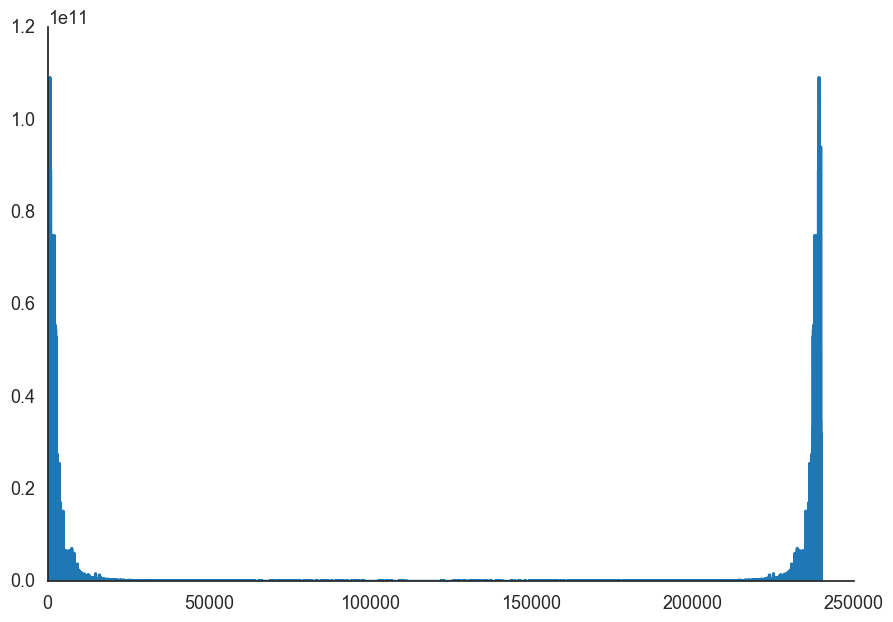

In [56]:
plt.plot(power)

In [92]:
from scipy import signal
import matplotlib.pyplot as plt
np.random.seed(1234)

In [135]:
# the sampling frequency
fs = 10e3 
# the number of values sampled
N = 1e5
# the amplitude of the singnal
amp = 2*np.sqrt(2)  
freq = 1234.0

# the amplituded of the noise
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs

# generate the signal
x = amp*np.sin(2*np.pi*freq*time)

# add ranodom noise. The power is the variance squared. 
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

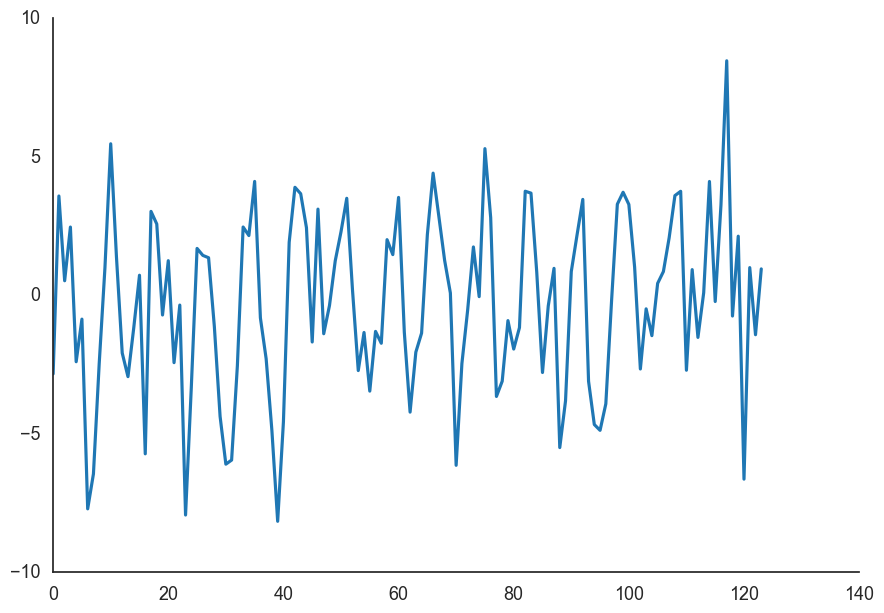

In [136]:
_=plt.plot(x[:124])

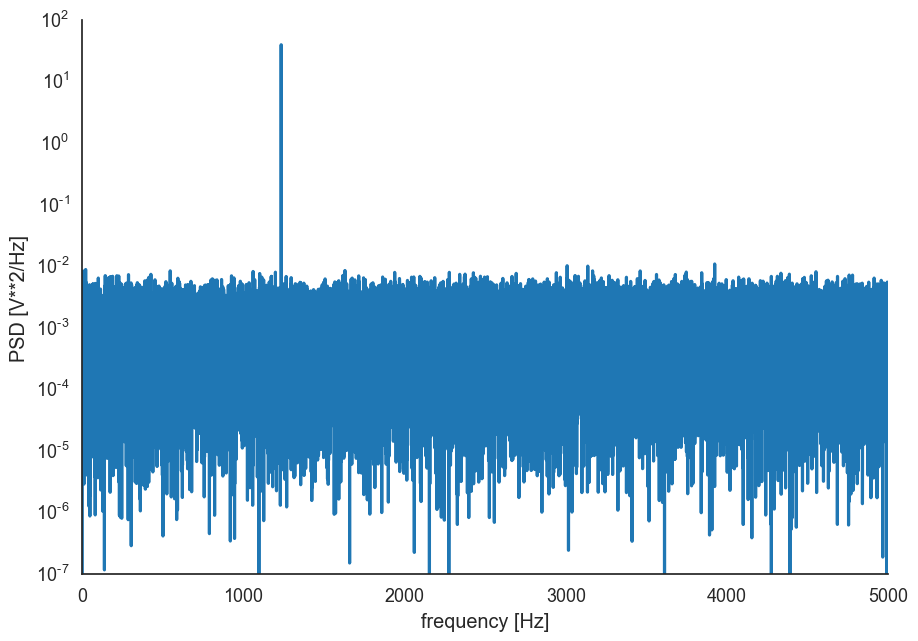

In [137]:
# comput the periodigram

f, Pxx_den = signal.periodogram(x, fs)
plt.semilogy(f, Pxx_den)
plt.ylim([1e-7, 1e2])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [138]:
np.mean(Pxx_den[256:])

0.0018033944033351093

In [142]:
# let generate our own signal 


# the sampling frequency
fs = 10e3 
# the number of values sampled
N = 1e2
# the amplitude of the singnal
amps = np.random.uniform(0.1,2, 6)
freq = 1234.0



# generate the signal
x = amp*np.sin(2*np.pi*freq*time)

# add ranodom noise. The power is the variance squared. 
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

In [144]:
?np.random.uniform